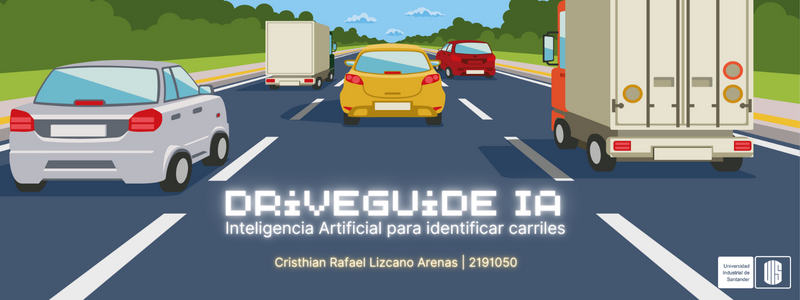

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***LIBRERIAS***

In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score, auc


In [ ]:
def deteccion_bordes(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    desenfoque = cv2.GaussianBlur(gris, (5, 5), 0)
    bordes = cv2.Canny(desenfoque, 50, 150)
    return bordes

def mostrar_lineas(imagen, lineas):
    imagen_lineas = np.zeros_like(imagen)
    if lineas is not None:
        for linea in lineas:
            x1, y1, x2, y2 = linea.reshape(4)
            cv2.line(imagen_lineas, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return imagen_lineas

def region_interes(imagen):
    altura = imagen.shape[0]
    poligonos = np.array([
        [(150, 650), (1100, 650), (600, 350)]
    ])
    mascara = np.zeros_like(imagen)
    cv2.fillPoly(mascara, poligonos, 255)
    imagen_mascarada = cv2.bitwise_and(imagen, mascara)
    return imagen_mascarada

carpeta_dataset = '/content/gdrive/MyDrive/Proyecto IA/DataSet/IMG DATASET'

rutas_imagenes_carril = [os.path.join(carpeta_dataset, imagen) for imagen in os.listdir(carpeta_dataset) if imagen.endswith('.png')]
pixeles_rojos_lista = []


imagenes_procesadas = []
etiquetas = []

for ruta_imagen in rutas_imagenes_carril:
    imagen = cv2.imread(ruta_imagen)
    imagen_carril = np.copy(imagen)
    imagen_bordes = deteccion_bordes(imagen_carril)
    imagen_recortada = region_interes(imagen_bordes)
    lineas = cv2.HoughLinesP(imagen_recortada, rho=2, theta=np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)
    imagen_lineas = mostrar_lineas(imagen_carril, lineas)

    # Ajustar el tamaño de imagen_lineas para que coincida con el de imagen_carril
    imagen_lineas = cv2.resize(imagen_lineas, (imagen_carril.shape[1], imagen_carril.shape[0]))

    imagen_lineas_gris = cv2.cvtColor(imagen_lineas, cv2.COLOR_BGR2GRAY)

    # Contar el número de píxeles no nulos (píxeles rojos) en la imagen de líneas
    pixeles_rojos_lineas = cv2.countNonZero(imagen_lineas_gris)

    pixeles_rojos_lista.append(pixeles_rojos_lineas)
    etiqueta = 1 if pixeles_rojos_lineas > 900 else 0
    etiquetas.append(etiqueta)
    imagenes_procesadas.append(imagen_lineas_gris)

# Verificar si la lista pixeles_rojos_lista contiene NaN y reemplazar por cero
pixeles_rojos_lista = np.nan_to_num(pixeles_rojos_lista)

etiquetas = np.where(np.array(etiquetas) > 0, 1, 0)


X = np.array(imagenes_procesadas)
X = X.reshape(X.shape[0], -1)  # Aplanar las imágenes en una columna

y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Crear y entrenar un modelo Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predecir en los conjuntos de entrenamiento y prueba
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# Calcular el acierto en los conjuntos de entrenamiento y prueba
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)


print("Acierto en el conjunto de entrenamiento (Random Forest):", accuracy_train_rf)
print("Acierto en el conjunto de prueba (Random Forest):", accuracy_test_rf)

print("Acierto en el conjunto de entrenamiento (Decision Tree):", accuracy_train_dt)
print("Acierto en el conjunto de prueba (Decision Tree):", accuracy_test_dt)



Acierto en el conjunto de entrenamiento (Random Forest): 0.9594339622641509
Acierto en el conjunto de prueba (Random Forest): 0.9509433962264151
Acierto en el conjunto de entrenamiento (Decision Tree): 0.9216981132075471
Acierto en el conjunto de prueba (Decision Tree): 0.8490566037735849


### ***RANDOM FOREST***

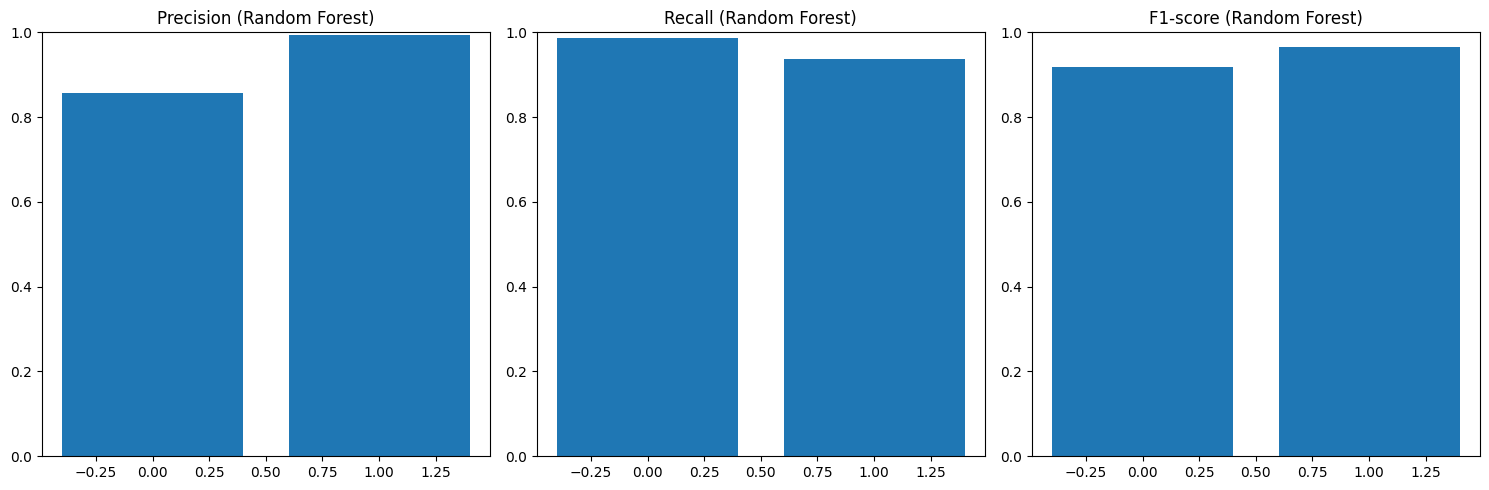

In [ ]:
# Obtener las métricas de precisión, recall y F1-score para cada clase
precision_rf = []
recall_rf = []
f1_score_rf = []

for class_label in np.unique(y_test):
    true_positive = np.sum((y_test == class_label) & (y_pred_test_rf == class_label))
    false_positive = np.sum((y_test != class_label) & (y_pred_test_rf == class_label))
    false_negative = np.sum((y_test == class_label) & (y_pred_test_rf != class_label))

    precision_rf.append(true_positive / (true_positive + false_positive))
    recall_rf.append(true_positive / (true_positive + false_negative))
    f1_score_rf.append(2 * (precision_rf[-1] * recall_rf[-1]) / (precision_rf[-1] + recall_rf[-1]))


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(np.unique(y_test), precision_rf)
axs[0].set_title("Precision (Random Forest)")
axs[0].set_ylim(0, 1)

axs[1].bar(np.unique(y_test), recall_rf)
axs[1].set_title("Recall (Random Forest)")
axs[1].set_ylim(0, 1)

axs[2].bar(np.unique(y_test), f1_score_rf)
axs[2].set_title("F1-score (Random Forest)")
axs[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### ***DECISION TREE***


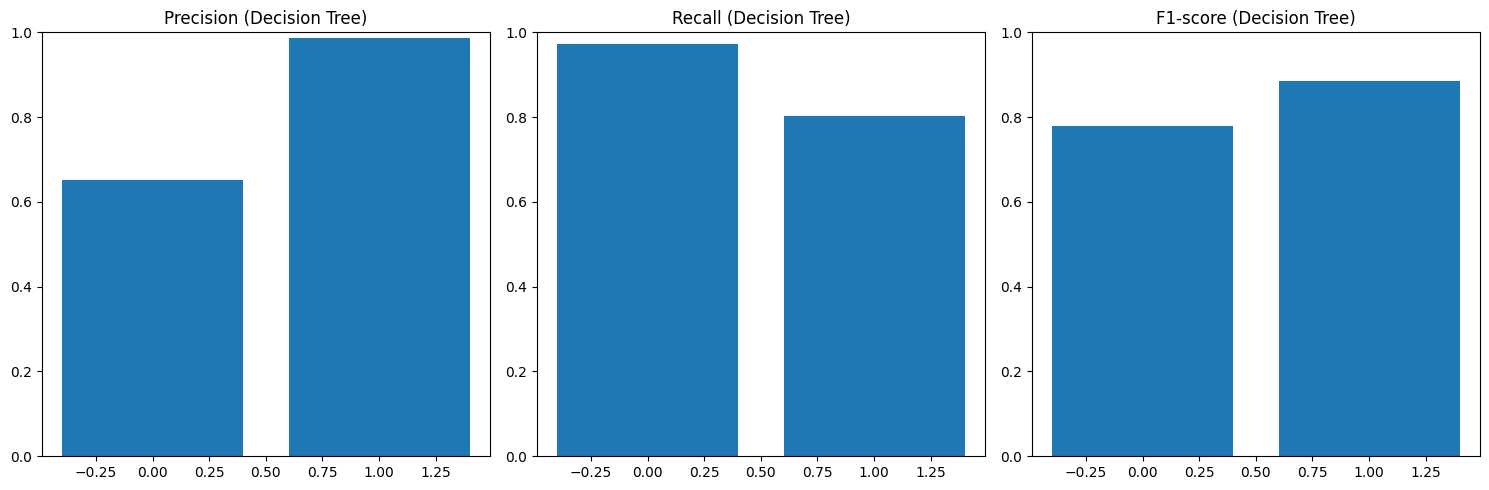

In [ ]:
precision_dt = []
recall_dt = []
f1_score_dt = []

for class_label in np.unique(y_test):
    true_positive = np.sum((y_test == class_label) & (y_pred_test_dt == class_label))
    false_positive = np.sum((y_test != class_label) & (y_pred_test_dt == class_label))
    false_negative = np.sum((y_test == class_label) & (y_pred_test_dt != class_label))

    precision_dt.append(true_positive / (true_positive + false_positive))
    recall_dt.append(true_positive / (true_positive + false_negative))
    f1_score_dt.append(2 * (precision_dt[-1] * recall_dt[-1]) / (precision_dt[-1] + recall_dt[-1]))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(np.unique(y_test), precision_dt)
axs[0].set_title("Precision (Decision Tree)")
axs[0].set_ylim(0, 1)

axs[1].bar(np.unique(y_test), recall_dt)
axs[1].set_title("Recall (Decision Tree)")
axs[1].set_ylim(0, 1)

axs[2].bar(np.unique(y_test), f1_score_dt)
axs[2].set_title("F1-score (Decision Tree)")
axs[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()
